## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

In [4]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. The number of unique users in the dataset.

In [5]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [6]:
con = df.query('converted == 1')['user_id'].count()

In [7]:
con / df['user_id'].nunique()

0.12126269856564711

e. The number of times the `new_page` and `treatment` don't match.

In [5]:
notmatch = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]

In [6]:
notmatch.count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.info() ## we dont have any missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(notmatch.index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [25]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [26]:
 df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [7]:
df2.drop_duplicates(subset =['user_id'] , inplace = True)
df2.duplicated().any()

False

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
new_p_count = df2.query('landing_page == "new_page"').count()['landing_page']
new_p_count / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Your answer goes here.**

According to the results, there is no sufficient evidence to conclude that the new treatment page leads to more conversions.
The control group has a slight difference conversions over the treatment group with 0.1 
Notice that the users of the new page are new users. and for the old page the users was an old users so we don't face change aversion and novetly effect. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

  ### H0 : **$p_{new}$** -  **$p_{old}$** <=  0 

 ### H1 : **$p_{new}$** - **$p_{old}$**  > 0 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [10]:
p_new = df2['converted'].mean()
p_new

0.11959667567149027

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [11]:
p_old = df2['converted'].mean()
p_old

0.11959667567149027

c. What is $n_{new}$, the number of individuals in the treatment group?

In [12]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145311

d. What is $n_{old}$, the number of individuals in the control group?

In [13]:
n_old= df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0,1] , n_new , p =[1-p_new, p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0,1] ,  n_old , p =[1-p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

-0.0013382552419036048

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
p_diffs =  []
for _ in range(10000):
    new_page = np.random.choice([0,1] , n_new , p= [1-p_new, p_new])
    old_page = np.random.choice([0,1] , n_old , p= [1-p_old, p_old])
    p_diffs.append(new_page.mean() - old_page.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

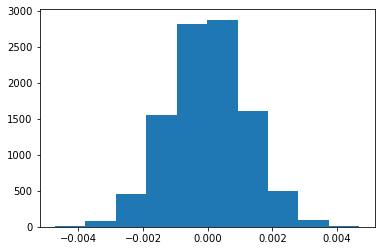

In [28]:
p_diffs= np.array(p_diffs)
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
new_page_act = df2.query('landing_page == "new_page"')['converted'].mean()
old_page_act = df2.query('landing_page == "old_page"')['converted'].mean()
diff = new_page_act - old_page_act

In [30]:
(p_diffs > diff ).mean()

0.9069

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

we have computed the P-value in part j. 
now we need to comapring the P-value with alpha level 0.05
### 0.90 > 0.05 
we fail to reject the null hypothesis. 
there is no difference in the conversion between the old and the new page. in fact, the old page could be better. 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

old_converted =  df2.query('landing_page == "old_page"')['converted'].sum()
new_converted =  df2.query('landing_page == "new_page"')['converted'].sum()
old_number =df2.query('landing_page == "old_page"')['user_id'].count()
new_number =df2.query('landing_page == "new_page"')['user_id'].count()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_scor , pvalue = sm.stats.proportions_ztest([old_converted,new_converted] ,[old_number ,new_number ] , alternative='smaller')

In [33]:
pvalue

0.905173705140591

In [34]:
z_scor

1.3116075339133115

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

when we compare the P-value with alpha level 0.05. we still Fail to reject the null hypothesis.
0.90 > 0.05 
there is no enough evidence to tell us to move to the new page. this means we should stay with the old page. 
The z score tells us how many standard deviations from the mean your score is. the score is 1.31 which is not significant.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression 

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['ab_page'] =pd.get_dummies(df2['group'])['treatment'] # to let treatment be 1 
df2.head(3)

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [104]:
df2['intercept'] = 1 

ml = sm.Logit(df2['converted'] , df2[['intercept' , 'ab_page']])
result = ml.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [42]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 08 Jul 2021   Pseudo R-squ.:               8.077e-06
Time:                        15:37:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

The P-value is 0.190. 

In the previous part we wanted to know which page had more conversion rate.  Here we would like to know if there is a significant difference in conversion based on which page the customer receives
 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

We need to add more variables to increase accuracy.one of the disadvantages from adding additional variables is Multicollinearity it occurs when independent variables in a regression model are correlated. This correlation is a problem because independent variables should be independent. If the degree of correlation between variables is high enough, it can cause problems when you fit the model and interpret the results. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
dfcity = pd.read_csv('countries.csv')
dfcity.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
merged = df2.merge(dfcity, on='user_id',how='left')
merged.to_csv("final_output.csv", index=False)
df3 = pd.read_csv('final_output.csv')
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,US


In [38]:
df3[['UK' , 'CA' , 'US']] = pd.get_dummies(df3['country'])
df3.head(2)

,user_id,timestamp,group,landing_page,converted,ab_page,country,UK,CA,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,US,0,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
df3['intercept'] = 1 
ml3 =sm.Logit(df3['converted'] , df3[['intercept' , 'CA' , 'US']])
result3 = ml3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Fri, 16 Jul 2021   Pseudo R-squ.:               1.521e-05
Time:                        20:33:15   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
CA             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [12]:
df3['ab_US'] = df3['US'] * df3['ab_page']
df3['ab_CA'] = df3['CA'] * df3['ab_page']

In [16]:
df3['intercept'] = 1 
ml3 =sm.Logit(df3['converted'] , df3[['intercept' , 'CA' , 'US' , 'ab_US' , 'ab_CA']])
result3 = ml3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Thu, 15 Jul 2021   Pseudo R-squ.:               2.691e-05
Time:                        08:13:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2205
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
CA             0.0453      0.031      1.481      0.139      -0.015       0.105
US             0.0511      0.028      1.841      0.066      -0.003       0.105
ab_US         -0.0206      0.014     -1.505      0.132      -0.047       0.006
ab_CA          0.0108      0.023      0.475      0.635      -0.034       0.056
==============================================================================
"""

as we can see there is no significant differnece.
the P-value is higher than our Alpha level. we fail to reject the null hypothesis. 

<a id='conclusions'></a>
## Finishing Up

Based on the statistical tests we used, the Z-test, logistic regression model, and actual difference observed, We failed to reject the null hypothesis. 
there is no significant differnece that drives us to move to the new page. 

 
## Rersouces 

https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/ 


https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html


In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])